In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env
from gymnasium.spaces import Discrete
import copy
import optuna

class WarehouseRobo(Env):
    def __init__(self,max_timesteps=100):
        super().__init__()
        self.action_space = Discrete(6)
        self.observation_space = Discrete(36)
        self.max_timesteps = max_timesteps
        self.grid_size = (6,6)
        self.obstacle_pos = [[2, 1], [3, 5]]
        self.state = {}
        self.item_held = False
        self.prev_state = None
        self.cumulative_reward = 0
        self.oneTime = False

    def reset(self):
        self.timesteps = 0
        self.cumulative_reward = 0
        self.agent_pos = [0,0]
        self.goal_pos = [5,5]
        while True:
            self.agent_pos = [np.random.randint(0, 6), np.random.randint(0, 6)]
            self.goal_pos = [np.random.randint(0, 6), np.random.randint(0, 6)]
            if self.agent_pos != self.goal_pos:
                break
        self.obstacle_pos = [[2, 1], [3, 5]]
        self.item_pos = [2, 2]
        if tuple(self.item_pos) in self.obstacle_pos:
            self.agent_pos = [0,0]
        if tuple(self.goal_pos) in self.obstacle_pos:
            self.goal_pos = [5,5]
        self.prev_state = copy.deepcopy(self.agent_pos)
        self.state = {}
        self.item_held = False
        self.oneTime = False
        self.initial_state()
        return self.state
    
    def initial_state(self):
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                self.state[(x, y)] = False
    
    def move_agent(self, action):
        status , reward = False, -1
        self.prev_state = copy.deepcopy(self.agent_pos)
        if action == 0 and self.agent_pos[0] > 0:  # Up
            self.agent_pos[0] -= 1
            status,reward = self.updateRewards(action)
        elif action == 1 and self.agent_pos[0] < self.grid_size[0] - 1:  # Down
            self.agent_pos[0] += 1
            status,reward = self.updateRewards(action)
        elif action == 2 and self.agent_pos[1] > 0:  # Left
            self.agent_pos[1] -= 1
            status,reward = self.updateRewards(action)
        elif action == 3 and self.agent_pos[1] < self.grid_size[1] - 1:  # Right
            self.agent_pos[1] += 1
            status,reward = self.updateRewards(action)
        elif action == 4 : # Pick-up
            if tuple(self.agent_pos) == tuple(self.item_pos):
                status,reward = self.updateRewards(action)
                if not self.oneTime and action == 4: #if item picked for first time
                        self.oneTime = True
                self.state[tuple(self.agent_pos)] = True
                self.item_held = True
            else:
                status,reward = self.updateRewards(action)
        elif action == 5: # Drop-off 
            if self.state[tuple(self.agent_pos)]:  
                status,reward = self.updateRewards(action)
                self.item_pos = self.agent_pos #update item position when dropped
                self.state[tuple(self.agent_pos)] = False
                self.item_held = False
            else:
                status,reward = self.updateRewards(action)
        
        if self.item_held:
            self.state[tuple(self.agent_pos)] = True
        else:
            self.state[tuple(self.agent_pos)] = False
        
        return status, reward

    def updateAgentPos(self):
        self.agent_pos = self.prev_state
    
    def updateRewards(self, action):
        AP = tuple(self.agent_pos)
        if AP == tuple(self.goal_pos) and self.state[AP] and action == 5:
            reward = 100 
            return True, reward
        elif AP == tuple(self.item_pos) and not self.state[AP] and action == 4 and not self.oneTime: 
            reward = 25 
        elif list(AP) in list(self.obstacle_pos):
            reward = -20
            self.updateAgentPos()
        else:
            reward = -1
        return False , reward

    def step(self, action):
        self.timesteps += 1
        status , reward = self.move_agent(action)
        self.cumulative_reward += reward
        if status:
            return self.state, reward, True, {}
        done = self.timesteps >= self.max_timesteps
        return self.state, reward, done, {}
    
    def render(self):
        grid = np.zeros(self.grid_size)
        grid[tuple(self.agent_pos)] = 2
        if not self.state[tuple(self.item_pos)]:
            grid[tuple(self.item_pos)] = 3
        for obs in self.obstacle_pos:
            grid[tuple(obs)] = -1
        grid[tuple(self.goal_pos)] = 1
        plt.imshow(grid, cmap="coolwarm", origin="upper")
        plt.colorbar(label="Grid Value")
        plt.xticks(range(self.grid_size[1]))
        plt.yticks(range(self.grid_size[0]))
        plt.title("Warehouse Robo Environment")
        plt.show()

In [47]:
import numpy as np
import random

class SARSA:
    def __init__(self, env, alpha=0.8, gamma=0.5, epsilon=1, epsilon_decay = 0.8, minimum_epsilon = 0.1, episodes=500, max_steps=100):
        self.env = env
        self.alpha = alpha       
        self.gamma = gamma        
        self.epsilon = epsilon   
        self.episodes = episodes  
        self.epsilon_decay = epsilon_decay
        self.minimum_epsilon = minimum_epsilon
        self.q_table = self.initialize_q_table()
        self.max_steps = max_steps

    def initialize_q_table(self):
        grid_size = self.env.grid_size
        action_space = self.env.action_space.n
        return np.zeros((grid_size[0]*grid_size[1], action_space))

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            actionValue = self.env.action_space.sample() 
            return actionValue  # Explore
        else:
            current_state = np.ravel_multi_index(state, self.env.grid_size)
            return np.argmax(self.q_table[current_state])   # Exploit

    def train(self):
        rewards = []
        epsilon_value = []
        actionPool = []

        for episode in range(self.episodes):
            _ = self.env.reset()
            state_pos = tuple(self.env.agent_pos)  # Get agent's starting position
            action = self.choose_action(state_pos)
            total_reward = 0
            actionTaken = []
            actionTaken.append(action)
            while True:
                _, reward, done, _ = self.env.step(action)
                actionTaken.append(action)
                # print("reward:",reward,"action: ",action)
                next_state_pos = tuple(self.env.agent_pos)
                total_reward += reward
                next_action = self.choose_action(next_state_pos)
                current_state = np.ravel_multi_index(state_pos, self.env.grid_size)
                next_state_index = np.ravel_multi_index(next_state_pos, self.env.grid_size)
                self.q_table[current_state, action] += self.alpha * (
                    reward + self.gamma * self.q_table[next_state_index, next_action]
                    - self.q_table[current_state, action]
                )
                
                state_pos = next_state_pos
                action = next_action

                if done:
                    break

            self.epsilon = max(self.epsilon * self.epsilon_decay, self.minimum_epsilon)
            rewards.append(total_reward)
            epsilon_value.append(self.epsilon)
            print(f"Episode {episode + 1}: Total Reward = {total_reward}")

            actionPool.append(actionTaken)
        return rewards,self.q_table , epsilon_value , actionPool

    def test(self):
        """Test the agent using the trained Q-table."""
        state = self.env.reset()
        state_pos = tuple(self.env.agent_pos)
        total_reward = 0

        for step in range(self.max_steps):
            action = np.argmax(self.q_table[state_pos])
            _, reward, done, _ = self.env.step(action)
            state_pos = tuple(self.env.agent_pos)
            total_reward += reward

            self.env.render()

            if done:
                break

        print(f"Total Reward for test: {total_reward}")


Episode 1: Total Reward = -15
Episode 2: Total Reward = -15
Episode 3: Total Reward = -53
Episode 4: Total Reward = -15
Episode 5: Total Reward = -53
Episode 6: Total Reward = -46
Episode 7: Total Reward = -15
Episode 8: Total Reward = -53
Episode 9: Total Reward = -34
Episode 10: Total Reward = -34
Episode 11: Total Reward = -72
Episode 12: Total Reward = -53
Episode 13: Total Reward = 11
Episode 14: Total Reward = -15
Episode 15: Total Reward = -15
Episode 16: Total Reward = -53
Episode 17: Total Reward = 11
Episode 18: Total Reward = -34
Episode 19: Total Reward = -72
Episode 20: Total Reward = -15
Episode 21: Total Reward = -15
Episode 22: Total Reward = -15
Episode 23: Total Reward = -8
Episode 24: Total Reward = -46
Episode 25: Total Reward = -15
Episode 26: Total Reward = -15
Episode 27: Total Reward = 11
Episode 28: Total Reward = -15
Episode 29: Total Reward = -15
Episode 30: Total Reward = -15
Episode 31: Total Reward = -15
Episode 32: Total Reward = -34
Episode 33: Total Rew

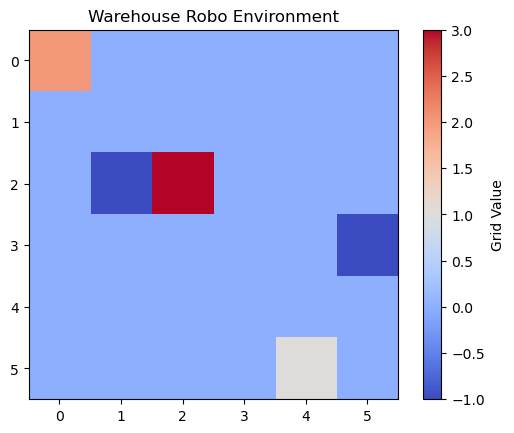

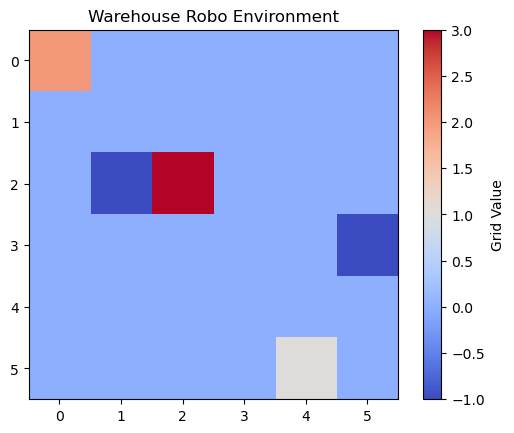

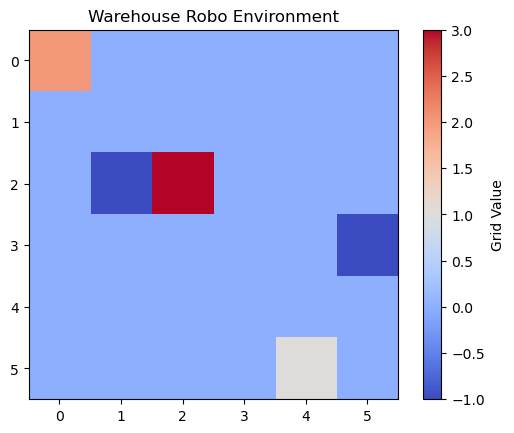

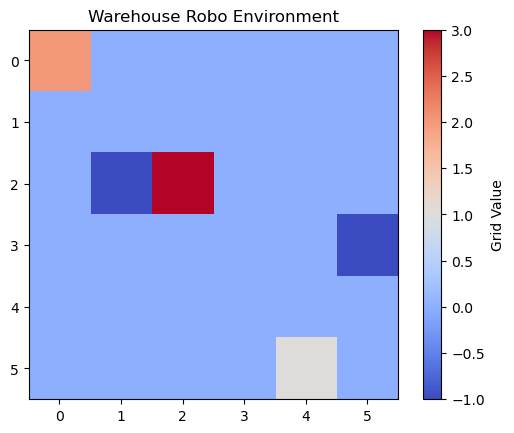

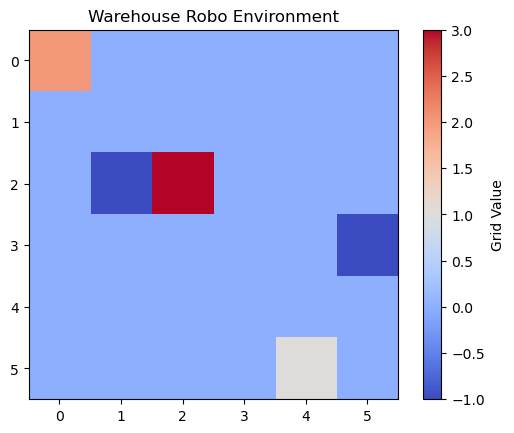

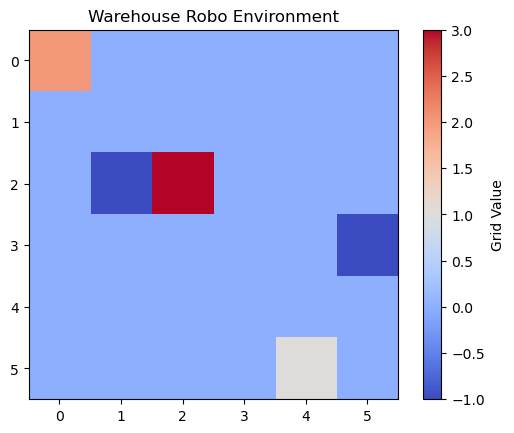

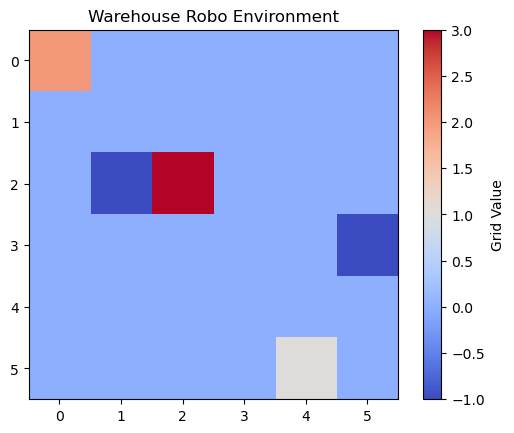

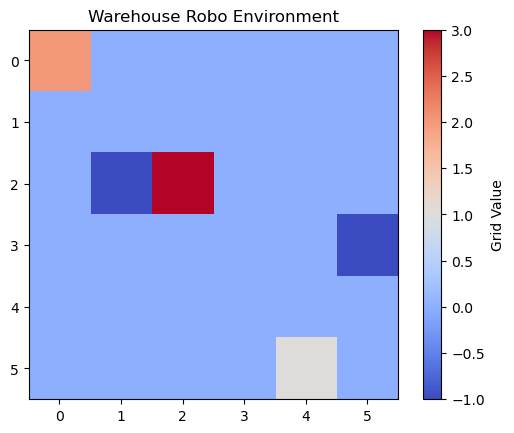

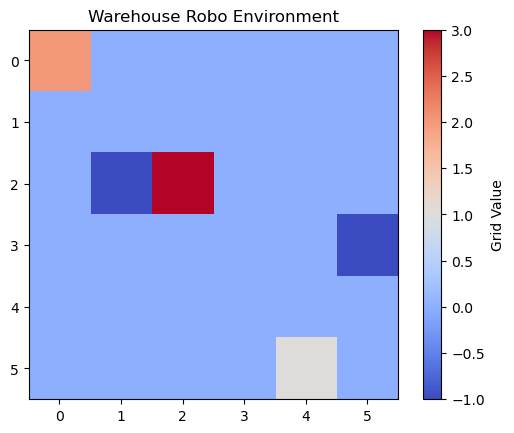

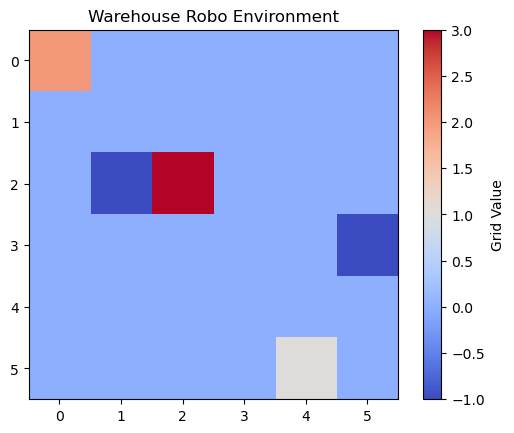

Total Reward for test: -10


In [51]:
env = WarehouseRobo(max_timesteps=15)
agent = SARSA(env, episodes=500, alpha=0.2, gamma=0.9, epsilon=1, epsilon_decay=0.99, minimum_epsilon=0.1,max_steps=10)
training_rewards,qTable,epsilon_values, ap = agent.train()
agent.test()


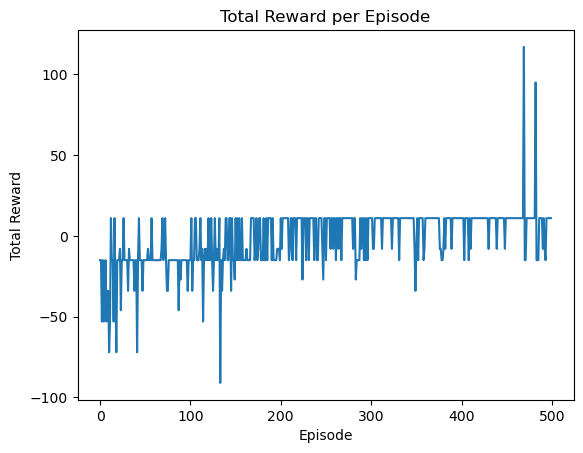

In [52]:
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.show()


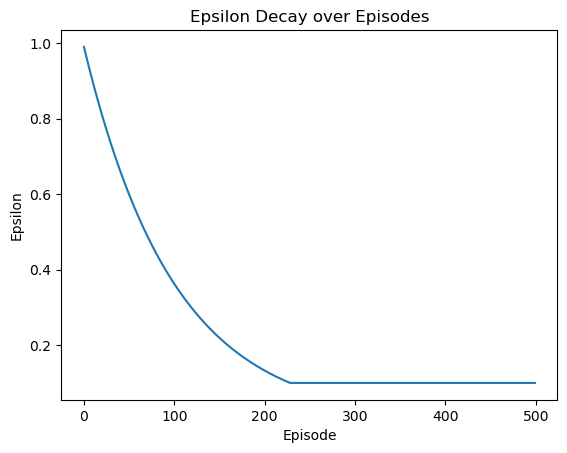

In [53]:
plt.plot(epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay over Episodes")
plt.show()


In [54]:
grid_size = env.grid_size
action_space = env.action_space.n
initial_Q = np.zeros((grid_size[0]*grid_size[1], action_space))
print("Initial Q-table:")
print(initial_Q)
print("\nTrained Q-table:")
print(qTable)


Initial Q-table:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

Trained Q-table:
[[-2.08506647e+00 -1.82676031e+00 -2.02204586e+00  1.05901838e-02
  -2.07911470e+00 -1.96715145e+00]
 [-1.80441920e+00 -1.64819241e+00 -1.76607029e+00  1.71045007e+00
  -1.98468217e+00 -1.45117639e+00]
 [-7.2

In [59]:
def objective(trial):
    gamma = trial.suggest_float("gamma", 0.89,1)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.7, 0.99)
    alpha = trial.suggest_float("alpha", 0.1, 0.5)
    env = WarehouseRobo(max_timesteps=20)
    agent = SARSA(
        env=env, episodes= 500, alpha=alpha, gamma=gamma, epsilon=1, epsilon_decay=epsilon_decay, minimum_epsilon=0.01,\
          max_steps=30)
    training_rewards,_,_, _ = agent.train()
    return np.mean(training_rewards)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


best_params = study.best_params
print("Best hyperparameters:", best_params)


[I 2024-12-05 19:49:39,827] A new study created in memory with name: no-name-3227165a-e042-476e-9d4f-fc137443978d
[I 2024-12-05 19:49:39,958] Trial 0 finished with value: -6.992 and parameters: {'gamma': 0.9664147216083019, 'epsilon_decay': 0.8371494477714615, 'alpha': 0.4722679351088506}. Best is trial 0 with value: -6.992.
[I 2024-12-05 19:49:40,081] Trial 1 finished with value: -2.254 and parameters: {'gamma': 0.964536343104549, 'epsilon_decay': 0.9053748884372816, 'alpha': 0.46714287050580894}. Best is trial 1 with value: -2.254.


Episode 1: Total Reward = -13
Episode 2: Total Reward = -58
Episode 3: Total Reward = -20
Episode 4: Total Reward = -13
Episode 5: Total Reward = -58
Episode 6: Total Reward = 6
Episode 7: Total Reward = -13
Episode 8: Total Reward = -39
Episode 9: Total Reward = -20
Episode 10: Total Reward = -58
Episode 11: Total Reward = 6
Episode 12: Total Reward = -20
Episode 13: Total Reward = -20
Episode 14: Total Reward = -13
Episode 15: Total Reward = -20
Episode 16: Total Reward = -58
Episode 17: Total Reward = -20
Episode 18: Total Reward = -20
Episode 19: Total Reward = -20
Episode 20: Total Reward = -20
Episode 21: Total Reward = -20
Episode 22: Total Reward = -20
Episode 23: Total Reward = -20
Episode 24: Total Reward = -20
Episode 25: Total Reward = -20
Episode 26: Total Reward = -58
Episode 27: Total Reward = -20
Episode 28: Total Reward = -20
Episode 29: Total Reward = -20
Episode 30: Total Reward = -20
Episode 31: Total Reward = -20
Episode 32: Total Reward = -20
Episode 33: Total Rew

[I 2024-12-05 19:49:40,220] Trial 2 finished with value: 3.194 and parameters: {'gamma': 0.9054733662222656, 'epsilon_decay': 0.8318242487492871, 'alpha': 0.15383413311183203}. Best is trial 2 with value: 3.194.


Episode 1: Total Reward = -20
Episode 2: Total Reward = -20
Episode 3: Total Reward = -20
Episode 4: Total Reward = 76
Episode 5: Total Reward = -20
Episode 6: Total Reward = -20
Episode 7: Total Reward = -58
Episode 8: Total Reward = 6
Episode 9: Total Reward = -58
Episode 10: Total Reward = -20
Episode 11: Total Reward = -77
Episode 12: Total Reward = -20
Episode 13: Total Reward = -20
Episode 14: Total Reward = -20
Episode 15: Total Reward = -58
Episode 16: Total Reward = -39
Episode 17: Total Reward = -20
Episode 18: Total Reward = 6
Episode 19: Total Reward = -20
Episode 20: Total Reward = -20
Episode 21: Total Reward = 6
Episode 22: Total Reward = 6
Episode 23: Total Reward = 6
Episode 24: Total Reward = -20
Episode 25: Total Reward = 6
Episode 26: Total Reward = 6
Episode 27: Total Reward = -20
Episode 28: Total Reward = -20
Episode 29: Total Reward = -20
Episode 30: Total Reward = -20
Episode 31: Total Reward = -58
Episode 32: Total Reward = 6
Episode 33: Total Reward = -20
Epi

[I 2024-12-05 19:49:40,341] Trial 3 finished with value: 2.684 and parameters: {'gamma': 0.9237121952796336, 'epsilon_decay': 0.9138174322876499, 'alpha': 0.20011582680721196}. Best is trial 2 with value: 3.194.


Episode 297: Total Reward = 6
Episode 298: Total Reward = 6
Episode 299: Total Reward = -13
Episode 300: Total Reward = 6
Episode 301: Total Reward = 6
Episode 302: Total Reward = 6
Episode 303: Total Reward = 6
Episode 304: Total Reward = 6
Episode 305: Total Reward = 6
Episode 306: Total Reward = -13
Episode 307: Total Reward = 6
Episode 308: Total Reward = 6
Episode 309: Total Reward = 6
Episode 310: Total Reward = 6
Episode 311: Total Reward = 6
Episode 312: Total Reward = 6
Episode 313: Total Reward = 6
Episode 314: Total Reward = 6
Episode 315: Total Reward = 6
Episode 316: Total Reward = 6
Episode 317: Total Reward = 6
Episode 318: Total Reward = 6
Episode 319: Total Reward = 6
Episode 320: Total Reward = 6
Episode 321: Total Reward = 6
Episode 322: Total Reward = 6
Episode 323: Total Reward = 6
Episode 324: Total Reward = 6
Episode 325: Total Reward = -13
Episode 326: Total Reward = 6
Episode 327: Total Reward = 6
Episode 328: Total Reward = 6
Episode 329: Total Reward = 6
Epis

[I 2024-12-05 19:49:40,498] Trial 4 finished with value: -8.602 and parameters: {'gamma': 0.8909512099301878, 'epsilon_decay': 0.9064344030803783, 'alpha': 0.40653787757640175}. Best is trial 2 with value: 3.194.
[I 2024-12-05 19:49:40,626] Trial 5 finished with value: -6.17 and parameters: {'gamma': 0.9482117440030564, 'epsilon_decay': 0.9301974362811993, 'alpha': 0.3515698045076603}. Best is trial 2 with value: 3.194.


Episode 482: Total Reward = 6
Episode 483: Total Reward = 6
Episode 484: Total Reward = 6
Episode 485: Total Reward = 6
Episode 486: Total Reward = 6
Episode 487: Total Reward = 6
Episode 488: Total Reward = 6
Episode 489: Total Reward = 6
Episode 490: Total Reward = 6
Episode 491: Total Reward = 6
Episode 492: Total Reward = 6
Episode 493: Total Reward = 6
Episode 494: Total Reward = 6
Episode 495: Total Reward = 6
Episode 496: Total Reward = 6
Episode 497: Total Reward = -13
Episode 498: Total Reward = -20
Episode 499: Total Reward = -20
Episode 500: Total Reward = -20
Episode 1: Total Reward = -20
Episode 2: Total Reward = -39
Episode 3: Total Reward = -39
Episode 4: Total Reward = -58
Episode 5: Total Reward = -20
Episode 6: Total Reward = -20
Episode 7: Total Reward = -20
Episode 8: Total Reward = -39
Episode 9: Total Reward = -58
Episode 10: Total Reward = -58
Episode 11: Total Reward = -115
Episode 12: Total Reward = -20
Episode 13: Total Reward = -20
Episode 14: Total Reward = 

[I 2024-12-05 19:49:40,763] Trial 6 finished with value: -1.244 and parameters: {'gamma': 0.9648917562303538, 'epsilon_decay': 0.7356321332432634, 'alpha': 0.46467909096962007}. Best is trial 2 with value: 3.194.
[I 2024-12-05 19:49:40,891] Trial 7 finished with value: 3.868 and parameters: {'gamma': 0.9914708410333923, 'epsilon_decay': 0.9049183148801698, 'alpha': 0.13037071617190676}. Best is trial 7 with value: 3.868.


Episode 261: Total Reward = 6
Episode 262: Total Reward = 6
Episode 263: Total Reward = 6
Episode 264: Total Reward = 6
Episode 265: Total Reward = 6
Episode 266: Total Reward = 6
Episode 267: Total Reward = 6
Episode 268: Total Reward = 6
Episode 269: Total Reward = 6
Episode 270: Total Reward = 6
Episode 271: Total Reward = 6
Episode 272: Total Reward = 6
Episode 273: Total Reward = 6
Episode 274: Total Reward = 6
Episode 275: Total Reward = 6
Episode 276: Total Reward = 6
Episode 277: Total Reward = 6
Episode 278: Total Reward = 6
Episode 279: Total Reward = 6
Episode 280: Total Reward = 6
Episode 281: Total Reward = 6
Episode 282: Total Reward = 6
Episode 283: Total Reward = 6
Episode 284: Total Reward = 6
Episode 285: Total Reward = 6
Episode 286: Total Reward = 6
Episode 287: Total Reward = 6
Episode 288: Total Reward = 6
Episode 289: Total Reward = 6
Episode 290: Total Reward = 6
Episode 291: Total Reward = 6
Episode 292: Total Reward = 6
Episode 293: Total Reward = 6
Episode 29

[I 2024-12-05 19:49:41,022] Trial 8 finished with value: 3.838 and parameters: {'gamma': 0.9404182843180647, 'epsilon_decay': 0.7271106911133307, 'alpha': 0.22544860577741843}. Best is trial 7 with value: 3.868.


Episode 87: Total Reward = 6
Episode 88: Total Reward = 6
Episode 89: Total Reward = 6
Episode 90: Total Reward = 6
Episode 91: Total Reward = 6
Episode 92: Total Reward = 6
Episode 93: Total Reward = 6
Episode 94: Total Reward = 6
Episode 95: Total Reward = 6
Episode 96: Total Reward = 6
Episode 97: Total Reward = 6
Episode 98: Total Reward = 6
Episode 99: Total Reward = 6
Episode 100: Total Reward = 6
Episode 101: Total Reward = 6
Episode 102: Total Reward = 6
Episode 103: Total Reward = 6
Episode 104: Total Reward = 6
Episode 105: Total Reward = 113
Episode 106: Total Reward = -20
Episode 107: Total Reward = -20
Episode 108: Total Reward = -20
Episode 109: Total Reward = 6
Episode 110: Total Reward = 6
Episode 111: Total Reward = 6
Episode 112: Total Reward = 6
Episode 113: Total Reward = 6
Episode 114: Total Reward = 6
Episode 115: Total Reward = 6
Episode 116: Total Reward = 6
Episode 117: Total Reward = 6
Episode 118: Total Reward = 6
Episode 119: Total Reward = 6
Episode 120: To

[I 2024-12-05 19:49:41,151] Trial 9 finished with value: -9.382 and parameters: {'gamma': 0.9005858784192662, 'epsilon_decay': 0.7524299423306174, 'alpha': 0.4964476134292483}. Best is trial 7 with value: 3.868.
[I 2024-12-05 19:49:41,285] Trial 10 finished with value: 0.306 and parameters: {'gamma': 0.9994738639155992, 'epsilon_decay': 0.9761218466042418, 'alpha': 0.2687211904801381}. Best is trial 7 with value: 3.868.


Episode 479: Total Reward = 6
Episode 480: Total Reward = -20
Episode 481: Total Reward = 6
Episode 482: Total Reward = 6
Episode 483: Total Reward = -20
Episode 484: Total Reward = -20
Episode 485: Total Reward = -20
Episode 486: Total Reward = -20
Episode 487: Total Reward = -20
Episode 488: Total Reward = 6
Episode 489: Total Reward = 6
Episode 490: Total Reward = -13
Episode 491: Total Reward = 6
Episode 492: Total Reward = 6
Episode 493: Total Reward = 6
Episode 494: Total Reward = 6
Episode 495: Total Reward = 6
Episode 496: Total Reward = -20
Episode 497: Total Reward = 6
Episode 498: Total Reward = 6
Episode 499: Total Reward = 6
Episode 500: Total Reward = 6
Episode 1: Total Reward = -20
Episode 2: Total Reward = -20
Episode 3: Total Reward = -58
Episode 4: Total Reward = -20
Episode 5: Total Reward = -58
Episode 6: Total Reward = -20
Episode 7: Total Reward = -39
Episode 8: Total Reward = -39
Episode 9: Total Reward = -58
Episode 10: Total Reward = -20
Episode 11: Total Rewar

[I 2024-12-05 19:49:41,421] Trial 11 finished with value: 4.174 and parameters: {'gamma': 0.9984236603742435, 'epsilon_decay': 0.7006214880069286, 'alpha': 0.10531379082303849}. Best is trial 11 with value: 4.174.
[I 2024-12-05 19:49:41,558] Trial 12 finished with value: 3.506 and parameters: {'gamma': 0.9989256942450917, 'epsilon_decay': 0.7850449033569826, 'alpha': 0.11421261764973398}. Best is trial 11 with value: 4.174.


Episode 298: Total Reward = 6
Episode 299: Total Reward = 6
Episode 300: Total Reward = 6
Episode 301: Total Reward = 6
Episode 302: Total Reward = 6
Episode 303: Total Reward = 6
Episode 304: Total Reward = 6
Episode 305: Total Reward = 6
Episode 306: Total Reward = 6
Episode 307: Total Reward = 6
Episode 308: Total Reward = 6
Episode 309: Total Reward = 6
Episode 310: Total Reward = 6
Episode 311: Total Reward = 6
Episode 312: Total Reward = 6
Episode 313: Total Reward = 6
Episode 314: Total Reward = 6
Episode 315: Total Reward = 6
Episode 316: Total Reward = 6
Episode 317: Total Reward = 6
Episode 318: Total Reward = 6
Episode 319: Total Reward = 6
Episode 320: Total Reward = 6
Episode 321: Total Reward = 6
Episode 322: Total Reward = 6
Episode 323: Total Reward = 6
Episode 324: Total Reward = 6
Episode 325: Total Reward = 6
Episode 326: Total Reward = 6
Episode 327: Total Reward = 6
Episode 328: Total Reward = 6
Episode 329: Total Reward = -13
Episode 330: Total Reward = 6
Episode 

[I 2024-12-05 19:49:41,724] Trial 13 finished with value: 3.092 and parameters: {'gamma': 0.9815417307746296, 'epsilon_decay': 0.8000450226318484, 'alpha': 0.10646295517537652}. Best is trial 11 with value: 4.174.


Episode 241: Total Reward = 6
Episode 242: Total Reward = 6
Episode 243: Total Reward = 6
Episode 244: Total Reward = 6
Episode 245: Total Reward = 6
Episode 246: Total Reward = 6
Episode 247: Total Reward = 6
Episode 248: Total Reward = 6
Episode 249: Total Reward = 6
Episode 250: Total Reward = 6
Episode 251: Total Reward = 6
Episode 252: Total Reward = 6
Episode 253: Total Reward = 6
Episode 254: Total Reward = 6
Episode 255: Total Reward = 6
Episode 256: Total Reward = 6
Episode 257: Total Reward = 6
Episode 258: Total Reward = 6
Episode 259: Total Reward = -13
Episode 260: Total Reward = 6
Episode 261: Total Reward = -13
Episode 262: Total Reward = 6
Episode 263: Total Reward = 6
Episode 264: Total Reward = 6
Episode 265: Total Reward = 6
Episode 266: Total Reward = 6
Episode 267: Total Reward = 6
Episode 268: Total Reward = 6
Episode 269: Total Reward = 6
Episode 270: Total Reward = 6
Episode 271: Total Reward = 6
Episode 272: Total Reward = 6
Episode 273: Total Reward = 6
Episod

[I 2024-12-05 19:49:41,853] Trial 14 finished with value: 3.336 and parameters: {'gamma': 0.9861507341253648, 'epsilon_decay': 0.8738509716554819, 'alpha': 0.17488836158847987}. Best is trial 11 with value: 4.174.
[I 2024-12-05 19:49:41,984] Trial 15 finished with value: 3.116 and parameters: {'gamma': 0.9781994369099668, 'epsilon_decay': 0.7047911483364973, 'alpha': 0.2687766014235002}. Best is trial 11 with value: 4.174.


Episode 437: Total Reward = 6
Episode 438: Total Reward = 6
Episode 439: Total Reward = 6
Episode 440: Total Reward = 6
Episode 441: Total Reward = 6
Episode 442: Total Reward = 6
Episode 443: Total Reward = 6
Episode 444: Total Reward = 6
Episode 445: Total Reward = 6
Episode 446: Total Reward = 6
Episode 447: Total Reward = 6
Episode 448: Total Reward = 6
Episode 449: Total Reward = 6
Episode 450: Total Reward = 6
Episode 451: Total Reward = 6
Episode 452: Total Reward = -13
Episode 453: Total Reward = 6
Episode 454: Total Reward = 6
Episode 455: Total Reward = 6
Episode 456: Total Reward = 6
Episode 457: Total Reward = 6
Episode 458: Total Reward = 6
Episode 459: Total Reward = 6
Episode 460: Total Reward = 6
Episode 461: Total Reward = 6
Episode 462: Total Reward = 6
Episode 463: Total Reward = 6
Episode 464: Total Reward = 6
Episode 465: Total Reward = 6
Episode 466: Total Reward = 6
Episode 467: Total Reward = 6
Episode 468: Total Reward = 6
Episode 469: Total Reward = 6
Episode 

[I 2024-12-05 19:49:42,119] Trial 16 finished with value: 1.506 and parameters: {'gamma': 0.9885789813436673, 'epsilon_decay': 0.9727175753476467, 'alpha': 0.14348385277319292}. Best is trial 11 with value: 4.174.
[I 2024-12-05 19:49:42,249] Trial 17 finished with value: 2.136 and parameters: {'gamma': 0.950125673785826, 'epsilon_decay': 0.8736410880956655, 'alpha': 0.22701963298129169}. Best is trial 11 with value: 4.174.


Episode 269: Total Reward = 6
Episode 270: Total Reward = 6
Episode 271: Total Reward = 6
Episode 272: Total Reward = 6
Episode 273: Total Reward = 6
Episode 274: Total Reward = 6
Episode 275: Total Reward = 6
Episode 276: Total Reward = 6
Episode 277: Total Reward = 6
Episode 278: Total Reward = 6
Episode 279: Total Reward = 6
Episode 280: Total Reward = 6
Episode 281: Total Reward = 6
Episode 282: Total Reward = 6
Episode 283: Total Reward = 6
Episode 284: Total Reward = 6
Episode 285: Total Reward = 6
Episode 286: Total Reward = 6
Episode 287: Total Reward = 6
Episode 288: Total Reward = 6
Episode 289: Total Reward = 6
Episode 290: Total Reward = 6
Episode 291: Total Reward = 6
Episode 292: Total Reward = 6
Episode 293: Total Reward = 6
Episode 294: Total Reward = 6
Episode 295: Total Reward = 6
Episode 296: Total Reward = 6
Episode 297: Total Reward = 6
Episode 298: Total Reward = 6
Episode 299: Total Reward = 6
Episode 300: Total Reward = 6
Episode 301: Total Reward = -13
Episode 

[I 2024-12-05 19:49:42,380] Trial 18 finished with value: 3.006 and parameters: {'gamma': 0.972477194851459, 'epsilon_decay': 0.7954638935042926, 'alpha': 0.3354316313350131}. Best is trial 11 with value: 4.174.


Episode 77: Total Reward = 6
Episode 78: Total Reward = 6
Episode 79: Total Reward = 6
Episode 80: Total Reward = 6
Episode 81: Total Reward = 6
Episode 82: Total Reward = 6
Episode 83: Total Reward = 6
Episode 84: Total Reward = 6
Episode 85: Total Reward = 6
Episode 86: Total Reward = 6
Episode 87: Total Reward = 6
Episode 88: Total Reward = -13
Episode 89: Total Reward = 6
Episode 90: Total Reward = 6
Episode 91: Total Reward = 6
Episode 92: Total Reward = 6
Episode 93: Total Reward = 6
Episode 94: Total Reward = 6
Episode 95: Total Reward = 6
Episode 96: Total Reward = 6
Episode 97: Total Reward = 6
Episode 98: Total Reward = 6
Episode 99: Total Reward = 6
Episode 100: Total Reward = 6
Episode 101: Total Reward = 6
Episode 102: Total Reward = 6
Episode 103: Total Reward = 6
Episode 104: Total Reward = 6
Episode 105: Total Reward = 6
Episode 106: Total Reward = 6
Episode 107: Total Reward = 6
Episode 108: Total Reward = 6
Episode 109: Total Reward = 6
Episode 110: Total Reward = 6
E

[I 2024-12-05 19:49:42,555] Trial 19 finished with value: 3.27 and parameters: {'gamma': 0.9316950412271835, 'epsilon_decay': 0.9465909441246414, 'alpha': 0.11236079704836968}. Best is trial 11 with value: 4.174.


Episode 362: Total Reward = 6
Episode 363: Total Reward = 6
Episode 364: Total Reward = 6
Episode 365: Total Reward = 6
Episode 366: Total Reward = 6
Episode 367: Total Reward = 6
Episode 368: Total Reward = 6
Episode 369: Total Reward = 6
Episode 370: Total Reward = 6
Episode 371: Total Reward = 6
Episode 372: Total Reward = 6
Episode 373: Total Reward = 6
Episode 374: Total Reward = 6
Episode 375: Total Reward = 6
Episode 376: Total Reward = 6
Episode 377: Total Reward = -13
Episode 378: Total Reward = 6
Episode 379: Total Reward = 6
Episode 380: Total Reward = 6
Episode 381: Total Reward = 6
Episode 382: Total Reward = 6
Episode 383: Total Reward = 6
Episode 384: Total Reward = 6
Episode 385: Total Reward = 6
Episode 386: Total Reward = 6
Episode 387: Total Reward = 6
Episode 388: Total Reward = 6
Episode 389: Total Reward = 6
Episode 390: Total Reward = 6
Episode 391: Total Reward = 6
Episode 392: Total Reward = 6
Episode 393: Total Reward = 6
Episode 394: Total Reward = 6
Episode 